## # Homework3-VAR model

 Data Processing and visualization

In [2]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

d:\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Load data
## the dataset is too large, to decrease the computing time, we use the weekly sale data of store 1

src_clean = 'C:/Users/wang/Downloads/clean_data.csv'
df_clean = pd.read_csv(src_clean)
df_clean["Date"] = pd.to_datetime(df_clean["Date"])
df_clean = df_clean.loc[(df_clean.Store == 1)]
df_clean.set_index('Date', inplace=True)

df_clean.head()

,Unnamed: 0,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,0,1,1,24924.50,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,1,1,2,50605.27,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,2,1,3,13740.12,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,3,1,4,39954.04,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,4,1,5,32229.38,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010


d:\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


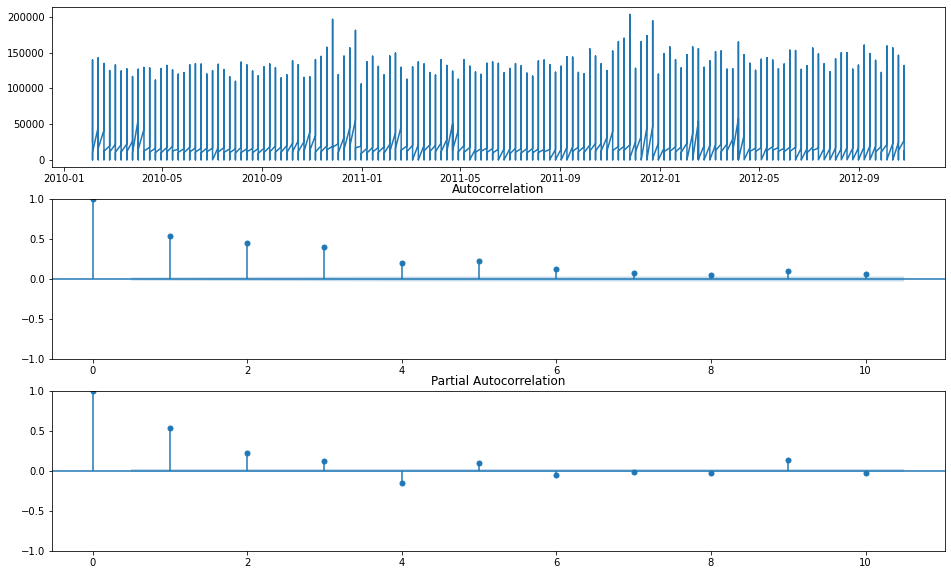

In [4]:
df=df_clean.copy()

# plots 
fig, axs = plt.subplots(3, 1,figsize=(16,10))
axs[0].plot(df['Weekly_Sales'])
sm.graphics.tsa.plot_acf(df.Weekly_Sales, lags=10, ax=axs[1]);
sm.graphics.tsa.plot_pacf(df.Weekly_Sales, lags=10, ax=axs[2]);

Question 1

1. Find a new series that could help in forecasting the series that you selected in HWI. For example,
if before you selected rGDP then add industrial production index to the model. If you selected
temperature measures, add temperature measures of neighbouring city/country or perhaps
precipitation data

 Walmart dataset has provided a data combining of 45 stores including store information and weekly sales. In fact, Walmart tries to find the impact of holidays on the sales of store. For which it has included four holidays’ weeks into the dataset which are Christmas, Thanksgiving, Super bowl, Labor Day. Hence, we use the holiday information to forcast the weekly sales.

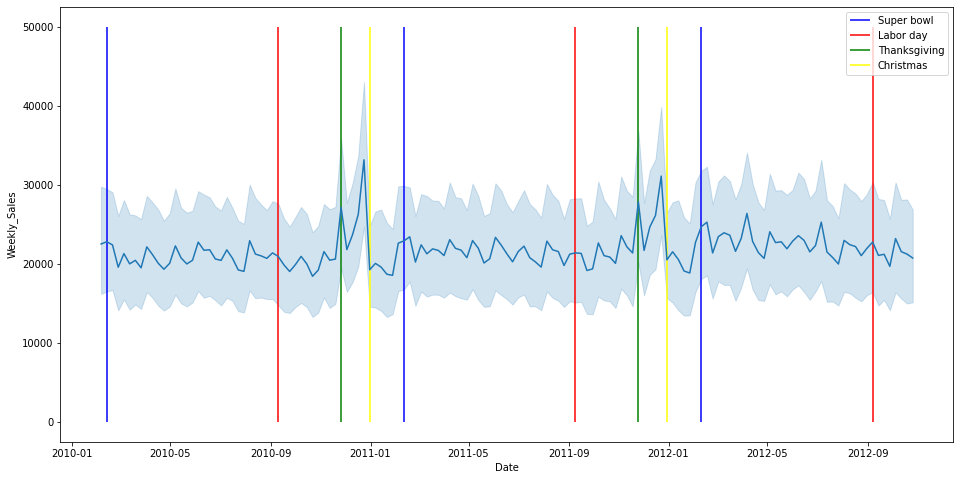

In [169]:
df=df_clean.copy()
special_dates = {
    'Super bowl': ['2010-02-12', '2011-02-11', '2012-02-10'],
    'Labor day': ['2010-09-10', '2011-09-09', '2012-09-07'],
    'Thanksgiving': ['2010-11-26', '2011-11-25'],
    'Christmas': ['2010-12-31', '2011-12-30']
}
colors = ['blue', 'red', 'green', 'yellow']
plt.figure(figsize=(16,8))
sns.lineplot(x='Date', y='Weekly_Sales', data=df)

# min and max values for vertical lines
max_val = 50000
min_val = df.Weekly_Sales.min()

for ix, event in enumerate(special_dates.keys()):
    
    plt.vlines(x      = special_dates[event], 
               colors = colors[ix],
               ymin   = min_val, 
               ymax   = max_val, 
               label  = event)
    
plt.legend()

plt.show()

In [6]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

week
51    32128.532345
47    27509.963931
50    26195.913889
49    24182.615556
7     23702.509028
Name: Weekly_Sales, dtype: float64

<AxesSubplot:xlabel='week'>

<Figure size 1152x576 with 0 Axes>

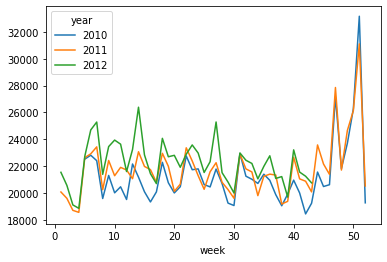

In [170]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()


1)As we can see, week 51 and 47 have higher values and 50-48 weeks follow them, during which people are prepared for Christmas, Thankgiving and Black Friday.

2)January sales are significantly less than other months. This is the result of November and December high sales. After two high sales month, people prefer to pay less on January.

In [131]:
# Difference
#In this data, there are lots of same data values. So, I collect them together as weekly.
df_week = df.resample('W').mean() #resample data as weekly

#df_week_diff = df_week['Weekly_Sales'].diff().dropna() #creating difference values
week_diff = pd.DataFrame.pct_change(df_week['Weekly_Sales']).dropna()
uem_diff =  pd.DataFrame.pct_change(df_week['Fuel_Price']).dropna()
df_week_diff = pd.concat([week_diff, uem_diff], axis=1)

In [132]:
adfuller_test = adfuller(df_week_diff['Fuel_Price'] , autolag='AIC')
adfuller_output = pd.Series(adfuller_test[0:3], index=['ADF Statistic','p-value','#Lags Used'])
for key,value in adfuller_test[4].items():
    adfuller_output['Critical Value (%s)'%key] = value
print(adfuller_output)

ADF Statistic          -6.757116e+00
p-value                 2.853142e-09
#Lags Used              0.000000e+00
Critical Value (1%)    -3.477601e+00
Critical Value (5%)    -2.882266e+00
Critical Value (10%)   -2.577822e+00
dtype: float64


From the p-value = 2.853142e-09< α = 0.05 , we can say that our series is stationary.

In [133]:
df_week_diff = df_week_diff[['Weekly_Sales','Fuel_Price']].dropna()

# Granger Causality Test

In [134]:
from statsmodels.tsa.stattools import grangercausalitytests

In [135]:
grangercausalitytests(df_week_diff[['Weekly_Sales','Fuel_Price']], maxlag=[10])


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9080  , p=0.5285  , df_denom=111, df_num=10
ssr based chi2 test:   chi2=10.7981 , p=0.3735  , df=10
likelihood ratio test: chi2=10.3791 , p=0.4079  , df=10
parameter F test:         F=0.9080  , p=0.5285  , df_denom=111, df_num=10


{10: ({'ssr_ftest': (0.9080204407916653, 0.528537300988945, 111.0, 10),
   'ssr_chi2test': (10.798080917522508, 0.37346433593112455, 10),
   'lrtest': (10.379118852417037, 0.40788478132225076, 10),
   'params_ftest': (0.9080204407916621, 0.5285373009889484, 111.0, 10.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          

We bserve that the p-vale (0.0009 ) < 0.05  thus Uemployment rate granger cause weekly sale index. 

In [136]:
def smooth_outliers(df,k,n):
    out = df.copy()               # copy current column 
    # loop over variables
    for col in df:                                    # loop over columns
        if pd.api.types.is_numeric_dtype(df[col]):    # if column is numeric
                # quartiles and inter-quartile range
                q1 = df[col].quantile(0.25)           # Q1
                q3 = df[col].quantile(0.75)           # Q3
                iqr = q3-q1                           # IQR
                ind = ~out[col].between(q1-k*iqr, q3+k*iqr, inclusive=False)               # logical index for outliers in df[col]
                col_sm = df[col].rolling(window=n,center=True,min_periods=None).mean()                      # smooth with rolling window 
                out.loc[ind,col] = col_sm[ind]                                             # replace outliers with two-sided rolling mean
                # col_sm = np.array(sm.tsa.filters.hpfilter(df[col],0.5)).transpose()      # smooth with hp filter 
                # ret.loc[ind,col] = col_sm[ind,1]                                         # replace outliers with hp trend
                
    return out

df_diff_sm = smooth_outliers(df_week_diff,4,6)

C:\Users\wang\AppData\Local\Temp/ipykernel_12068/732014244.py:10: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  ind = ~out[col].between(q1-k*iqr, q3+k*iqr, inclusive=False)               # logical index for outliers in df[col]


2. Take stationary series (from step 1), reserve the first 80% of the sample for estimation and
select an appropriate ARIMA model. Justify your choice.

In [137]:
#Train-Test Split
train_data_diff = df_week_diff [:int(0.8*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.8*(len(df_week_diff ))):]

In [138]:
#Train-Test Split
train_data_sm = df_diff_sm [:int(0.8*(len(df_week_diff )))]
test_data_sm = df_diff_sm [int(0.8*(len(df_week_diff ))):]


In [148]:
Y = sm.tsa.VAR(train_data_diff)
res = sm.tsa.VAR.select_order(Y,12)
res.summary()

,AIC,BIC,FPE,HQIC
0,-12.42,-12.37,4.042e-06,-12.40
1,-12.71,-12.55*,3.023e-06,-12.65*
2,-12.73,-12.47,2.954e-06,-12.63
3,-12.78,-12.42,2.823e-06,-12.63
4,-12.79*,-12.32,2.798e-06*,-12.60
5,-12.76,-12.19,2.881e-06,-12.53
6,-12.75,-12.08,2.908e-06,-12.48
7,-12.69,-11.91,3.098e-06,-12.37
8,-12.66,-11.78,3.189e-06,-12.31
9,-12.64,-11.66,3.259e-06,-12.24


In [140]:
#  Perform rolling one-step-ahead forecast 
# Let's first move the date into index
# df_diff.index = df.index[1:]

Y = train_data_diff[['Weekly_Sales','Fuel_Price']]
n_fcs = int(test_data_diff.shape[0])
n = Y.shape[0] 
fcs = np.empty((n_fcs,2,))
fcs[:] = np.nan
for i in range(0,n_fcs):                          # loop for 1-step-ahead forecasts on the last 10% of the data
    
    var_i   = sm.tsa.VAR(Y[0:(n-(n_fcs-i))])      # declare var model object
    mdl_i   = var_i.fit(2)                        # fit var model
    fcs_i   = mdl_i.forecast(y=np.array(test_data_diff.iloc[0:(n-(n_fcs-i)),:]), steps=1); # one-step-ahead forecast
    fcs[i,:] = fcs_i                              # store the forecast

In [195]:
Y_train = sm.tsa.VAR(train_data_diff) 
Y_test = test_data_diff
n_fcs = int(test_data_diff.shape[0])
n = train_data_diff.shape[0] 
fcs = np.empty((n_fcs,2,))
fcs[:] = np.nan
rmse = np.empty((1,2,))
rmse[:] = np.nan

for p in range(1,30,5):                                 
    mdl = Y_train.fit(p)                              
    for i in range(0,n_fcs):                          
        Y_test_i = Y.y[0:(n-(n_fcs-i)),:]  
        fcs_i = mdl.forecast(y=Y_test_i, steps=1)     
        fcs[i,:] = fcs_i    
    rmse[0,0:2] = sm.tools.eval_measures.rmse(Y_test,fcs,0)                     
    #rmse  = pd.DataFrame(rmse,columns=['Umeployment_rate','Production index'])
    print("RMSE, P=", p )
    print(rmse)


RMSE, P= 1
[[0.09951108 0.01647892]]
RMSE, P= 6
[[0.12016723 0.01755918]]
RMSE, P= 11
[[0.11808989 0.01836361]]
RMSE, P= 16
[[0.11643935 0.01798087]]
RMSE, P= 21
[[0.11668031 0.01946907]]
RMSE, P= 26
[[0.13196233 0.02106681]]


C:\Users\wang\AppData\Local\Temp/ipykernel_12068/3593997987.py:13: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  Y_test_i = Y.y[0:(n-(n_fcs-i)),:]


As we can see, at p = 1, we obtain the smallest RMSE for the industral production using the VAR model. 

Text(0.5, 1.0, 'Fuel_Price')

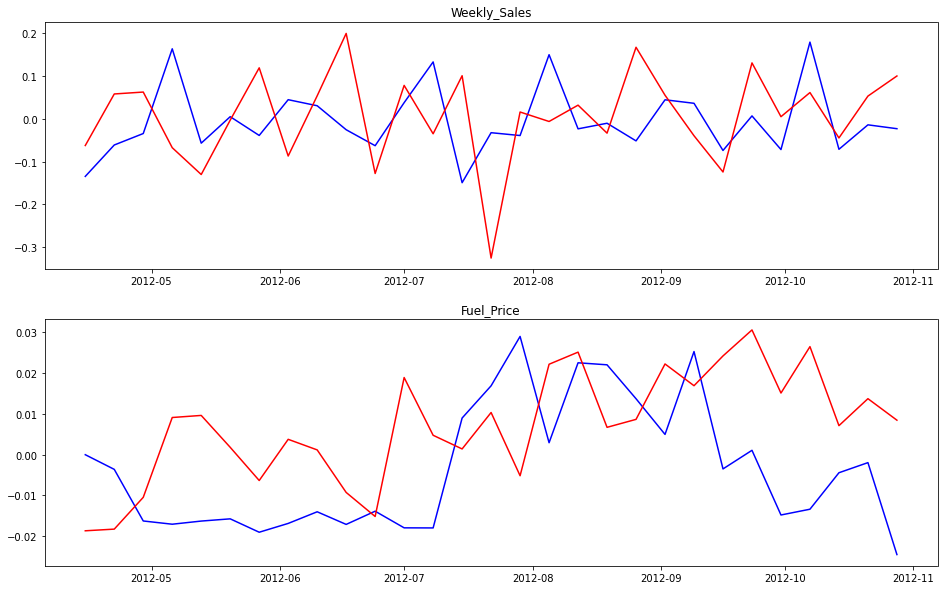

In [196]:
# y corresponding to forecasted values
y_true = test_data_diff
fcs = pd.DataFrame(fcs)
fcs.index = y_true.index
fcs.columns  = y_true.columns

# plot true and forecasted 
fig, axs = plt.subplots(2, 1,figsize=(16,10))
axs[0].plot(y_true['Weekly_Sales'],'b-')
axs[0].plot(fcs['Weekly_Sales'],'r-')
axs[0].set_title('Weekly_Sales')
axs[1].plot(y_true['Fuel_Price'],'b-')
axs[1].plot(fcs['Fuel_Price'],'r-')
axs[1].set_title('Fuel_Price')